# Code for MHLLCEP Riemann solver with a high-order cell-center Lagrangian schemes

In [23]:
struct Global
    nv          ::Int    #boundary point
    jx          ::Int    #cell number
    #nm          ::Int    #N of matter
    kindProblem ::Int #kind of problem
    tt          ::Float64      #total time
    cfl         ::Float64     # cfl
end

struct Const
    Y0 ::Float64
    ρ0 ::Float64
    Γ0 ::Float64
    μ  ::Float64
    a0 ::Float64
    s0 ::Float64
end
    

struct Var
    ρ ::Float64
    u ::Float64
    p ::Float64
    sxx::Float64
end


$$ 1Pa = 1N/m^2 = 1 kg/(m\cdot s^2) = 10^{-11} g/(cm \cdot \mu s^2)$$ 

$$ 1 m/s = 10^{-4} cm/\mu s$$
$$ 1kg/m^3 = 10^{-3} g/cm^3$$


$$f(\eta) = \frac{(\eta-1)(\eta-\Gamma_0(\eta-1)/2)}{(\eta-s_0(\eta-1))^2}$$
$$f'(\eta) = \frac{\eta+(s_0-\Gamma_0)(\eta-1)}{(\eta-s_0(\eta-1))^3}$$

In [24]:
function fη(ρ::Float64,c::Const)
    η = ρ/c.ρ0
    fη=(η-1.0)*(η-c.Γ0*(η-1.0)/2.0)/(η-c.s0*(η-1))^2
end

function fηη(ρ::Float64,c::Const)
    η = ρ/c.ρ0
    fηη=(η+(c.s0-c.Γ0)*(η-1))/(η-c.s0*(η-1))^3
end


fηη (generic function with 1 method)

Mie-Gr\"uneisen equation of state
$$e =\frac{p-\rho_0a_0^2f(\eta)}{\rho_0\Gamma_0}$$

$$p = \rho_0a_0^2f(\eta)+\rho_0\Gamma_0e$$

In [25]:
function PToe(ρ::Float64,p::Float64,con::Const)
    c=con
    ei = (p-c.ρ0*c.a0^2*fη(ρ,c))/(c.ρ0*c.Γ0)
    return ei
end
function EToP(ρ::Float64,ei::Float64,con::Const)
    c=con
    p = c.ρ0*c.Γ0*ei+c.ρ0*c.a0^2*fη(ρ,c)
    return p
end

EToP (generic function with 1 method)

$$ \begin{aligned}
    & \rho = uo[1]\\
    & u  = uo[2]\\
    & p =uo[3]\\
    & s_{xx}=uo[4]
     \end{aligned} \hspace{0.3cm}
    \begin{aligned}
    &U[1]=\rho\\
    &U[2]=\rho u\\
    &U[3]=\rho E\\
    &U[4]=s_{xx}\\
    \end{aligned}
$$

$$ e=E/\rho-\frac{1}{2}u^2$$


In [26]:
"""
 from  the primitive variables uo to  conservative variables U
"""
function UoTou(uo::Array{Float64,1},con::Const)
    u = zeros(Float64, 4)
    u[1]=uo[1]
    u[2]=uo[2]*uo[1]
    ei = PToe(uo[1],uo[3],con)
    u[3]=(ei+0.5uo[2]^2)*uo[1]
    u[4]=uo[4]
    return u
end

UoTou

In [27]:
"""
 from conservative variables U  to  the primitive variables uo
"""
function UToUo(u::Array{Float64,1},con::Const)
    uo = zeros(Float64, 4)
    uo[1]=u[1]
    uo[2]=u[2]/u[1]
    ei=u[3]/uo[1]-0.5uo[2]^2
    p = EToP(uo[1],ei,con)
    uo[3]=p
    uo[4]=u[4]
    return uo
end  

UToUo

$$ c=\sqrt{a^2-\frac{\rho_0}{\rho^2}\Gamma_0s_{xx}+\frac{4}{3}\frac{\mu}{\rho}}$$
$$ a^2= a_0^2 f'(\eta)+\frac{p}{\rho^2}\rho_0\Gamma_0$$

if $|s_{xx}| \ge \frac{2}{3}Y_0$ then sound speed is change to 
$$ c=\sqrt{a^2-\frac{\rho_0}{\rho^2}\Gamma_0s_{xx}}$$

In [28]:
function sound(uo::Array{Float64,1},con::Const,EoP::Int=1)
    a0  = con.a0
    ρ0  = con.ρ0
    Γ0  = con.Γ0
    Y0  = con.Y0
    μ   = con.μ
    ρ   = uo[1]
    uu  = uo[2]
    p   = uo[3]
    sxx = uo[4]
    a2  = a0^2*fηη(ρ,con)+p/ρ^2*ρ0*Γ0
  #  c = ftest(a2,ρ0,ρ,Γ0,sxx,μ,a0,fηη(ρ,con),p)
    if EoP == 2
        c=sqrt(a2-ρ0/ρ^2*Γ0*sxx)
        return c
    else
        c=sqrt(a2-ρ0/ρ^2*Γ0*sxx+4.0/3*μ/ρ)
        return c
    end
end

function sound(U::Const,con::Const,EoP::Int = 1)
    a0,ρ0,Γ0,μ,Y0 = con.a0, con.ρ0, con.Γ0, con.μ,con.Y0
    ρ,u,p,sxx    = U.ρ, U.u,U.p,U.sxx
    a2  = a0^2*fηη(ρ,con)+p/ρ^2*ρ0*Γ0 
    if EoP == 2
        c=sqrt(a2-ρ0/ρ^2*Γ0*sxx)
        return c
    else
        c=sqrt(a2-ρ0/ρ^2*Γ0*sxx+4.0/3*μ/ρ)
        return c
    end
end


sound (generic function with 4 methods)

In [29]:
function Cfl(uo::Array{Float64,2},x::Array{Float64,1},
        inter::Array{Int,1},problem::Global=problem )
    nv=problem.nv
    jx=problem.jx
    sf=problem.cfl
    
   dx1=0
   dxmin=x[nv+2]-x[nv+1]
    for i in nv+2:jx+nv+1
        dx  = x[i]-x[i-1]
        if inter[i] == 1
            c = sound(uo[i,:],con1)
        else
            c = sound(uo[i,:],con2)
        end
        dxmin = min(dx,dxmin)
        dx1=dxmin/c
    end
   dt=sf*dx1
   return dt
end    

Cfl (generic function with 2 methods)

In [30]:
function WENO3(u::Array{Float64,1})
    ε = 1.e-4
    I, = size(u)
    uL = zeros(Float64,I)
    uR = zeros(Float64,I)
    for i in 2:I-1
        IS0 = (u[i] - u[i-1])^2
        IS1 = (u[i+1] - u[i])^2
        
        c0 = 2/3
        c1 = 1/3
        
        α0 = c0/(ε + IS0)
        α1 = c1/(ε + IS1)
        
        β0 = α0/(α0+α1)
        β1 = α1/(α0+α1)
        
     #   β0 = c0
     #   β1 = c1
        
        uR[i-1] = β0*(u[i]+u[i-1])/2+β1*(3u[i]-u[i+1])/2
        
        c0 = 1/3
        c1 = 2/3
        
        α0 = c0/(ε + IS0)
        α1 = c1/(ε + IS1)
        
        β0 = α0/(α0+α1)
        β1 = α1/(α0+α1)
     #   β0 = c0
     #   β1 = c1
        uL[i] = β0*(3u[i]-u[i-1])/2+β1*(u[i]+u[i+1])/2
    end
    return uL,uR
end

function WENO3_new(u::Array{Float64,1})
    ε = 1.e-6
    I, = size(u)
    uL = zeros(Float64,I)
    uR = zeros(Float64,I)
    for i in 2:I-2
        q0 = u[i] - u[i-1]
        q1 = u[i+1] - u[i]
 
        β0 = (abs(q0+q1)-abs(3q0-q1))^2+ε 
        β1 = (abs(q0+q1)-abs(3q1-q0))^2+ε
        
         w = 1.0/(1.0+2.0(β0/β1))
        uL[i] = u[i] + (w*(q0-q1)+ q1)/2
        
        q0 = u[i+1] - u[i+2]
        q1 = -q1
        
        β0 = (abs(q0+q1)-abs(3q0-q1))^2+ε 
        β1 = (abs(q0+q1)-abs(3q1-q0))^2+ε
        
        uR[i] = u[i+1] + (w*(q0-q1)+ q1)/2
    end
    return uL,uR
end


function WENO3(u::Array{Float64,1},inter::Array{Int,1},ik::Int)
    
    ε = 1.e-10
    I, = size(u)
    uL = zeros(Float64,I)
    uR = zeros(Float64,I)
    
    for i in 2:I-1
        
        if inter[i] != inter[i+1] #&& (ik == 4 || ik == 3) 
                
            IS0 = (u[i] - u[i-1])^2
            IS1 = 0  #(u[i+1] - u[i])^2

            c0 = 2/3
            c1 = 1/3

            α0 = c0/(ε + IS0)
            α1 = c1/(ε + IS1)

            β0 = α0/(α0+α1)
            β1 = α1/(α0+α1)
             uR[i-1] = β0*(u[i]+u[i-1])/2+β1*u[i]
             uR[i-1] = u[i]

            c0 = 1/3
            c1 = 2/3

            α0 = c0/(ε + IS0)
            α1 = c1/(ε + IS1)

            β0 = α0/(α0+α1)
            β1 = α1/(α0+α1)
             uL[i] = β0*(3u[i]-u[i-1])/2+β1*u[i]
               uL[i] = u[i]
        elseif inter[i] != inter[i-1] #&& (ik == 4 || ik ==3)
            IS0 = 0 # (u[i] - u[i-1])^2
            IS1 = (u[i+1] - u[i])^2
        
            c0 = 2/3
            c1 = 1/3
        
            α0 = c0/(ε + IS0)
            α1 = c1/(ε + IS1)
            
            β0 = α0/(α0+α1)
            β1 = α1/(α0+α1)
            
            uR[i-1] = β0*u[i]+β1*(3u[i]-u[i+1])/2
            uR[i-1] = u[i]
            c0 = 1/3
            c1 = 2/3
            
            α0 = c0/(ε + IS0)
            α1 = c1/(ε + IS1)
            
            β0 = α0/(α0+α1)
            β1 = α1/(α0+α1)
            
            uL[i] = β0*u[i]+β1*(u[i]+u[i+1])/2
          ##  uR[i-1] = u[i]
            uL[i] =u[i]
         else
            IS0 = (u[i] - u[i-1])^2
            IS1 = (u[i+1] - u[i])^2
            
            c0 = 2/3
            c1 = 1/3
            
            α0 = c0/(ε + IS0)
            α1 = c1/(ε + IS1)
            
            β0 = α0/(α0+α1)
            β1 = α1/(α0+α1)
            
            uR[i-1] = β0*(u[i]+u[i-1])/2+β1*(3u[i]-u[i+1])/2
            
            c0 = 1/3
            c1 = 2/3
            
            α0 = c0/(ε + IS0)
            α1 = c1/(ε + IS1)
            
            β0 = α0/(α0+α1)
            β1 = α1/(α0+α1)
            
            uL[i] = β0*(3u[i]-u[i-1])/2+β1*(u[i]+u[i+1])/2
        end
    end
    return uL,uR
end

WENO3 (generic function with 2 methods)

In [31]:
function Upwind(u::Array{Float64,1})
     I, = size(u)
    uL = zeros(Float64,I)
    uR = zeros(Float64,I)
    for i in 2:I-1
        uL[i] = u[i]
        uR[i] = u[i+1]
    end
    return uL,uR
end


Upwind (generic function with 1 method)

In [32]:
function Yυ(s::Float64,con::Const=con)
    Y0 = con.Y0
    f=0
    if abs(s) <= 2Y0/3
        f = s
    elseif s > 2Y0/3
        f = 2Y0/3
    else
        f = -2Y0/3
    end
end

Yυ (generic function with 2 methods)

In [33]:
function HLLCEPNew1(u::Array{Float64,1},uL::Array{Float64,2},uR::Array{Float64,2},
        inter::Array{Int,1},problem::Global=problem)

    nv = problem.nv
    jx = problem.nv
   
    I,J = size(uL)
    f  = zeros(Float64,(I,J))
    uuh = zeros(Float64,I)
    ue = zeros(Float64,J)
    
    for  i in 1:I
           if inter[i] == 1 
            conL = con1
            conR = con1
            Y0L = con1.Y0
            ρ0L = con1.ρ0
            Γ0L = con1.Γ0
            a0L = con1.a0
            μL  = con1.μ

            Y0R = con1.Y0
            ρ0R = con1.ρ0
            Γ0R = con1.Γ0
            a0R = con1.a0
            μR  = con1.μ
        else
            conL = con2
            conR = con2
            Y0L = con2.Y0
            ρ0L = con2.ρ0
            Γ0L = con2.Γ0
            a0L = con2.a0
            μL  = con2.μ

            Y0R = con2.Y0
            ρ0R = con2.ρ0
            Γ0R = con2.Γ0
            a0R = con2.a0
            μR  = con2.μ
             
        end
        if inter[i]==1 && inter[i+1] == 2
            conL = con1
            Y0L = con1.Y0
            ρ0L = con1.ρ0
            Γ0L = con1.Γ0
            a0L = con1.a0
            μL  = con1.μ
            
            conR = con2
            Y0R = con2.Y0
            ρ0R = con2.ρ0
            Γ0R = con2.Γ0
            a0R = con2.a0
            μR  = con2.μ
       end
       
        
        ρL =  uL[i,1]
        uuL = uL[i,2]
        pL  = uL[i,3]
        sxxL= uL[i,4]
        σL  = -pL+sxxL
        cL = sound(uL[i,:],conL)
        eL = PToe(ρL, pL, conL)
        
        ρR =  uR[i,1]
        uuR = uR[i,2]
        pR  = uR[i,3]
        sxxR= uR[i,4]
        σR  = -pR+sxxR
        cR = sound(uR[i,:],conR)
        eR = PToe(ρR, pR, conR)
        
        sL = min(uuL-cL, uuR-cR)
        sR = max(uuL+cL, uuR+cR)
        
        s_star = (σL - σR + ρL*uuL*(sL-uuL) - ρR* uuR*(sR-uuR))/(ρL*(sL-uuL)-ρR*(sR-uuR))
        
        ρLstar = ρL*(uuL-sL)/(s_star - sL)
        ρRstar = ρR*(uuR-sR)/(s_star - sR)
        
        tmp = -4.0μL/3*log(ρLstar/ρL) +sxxL
        if (abs(sxxL) < 2Y0L/3 && abs(tmp) >= 2Y0L/3)

       # if abs(tmp) >= 2Y0/3 
            if tmp > 2Y0L/3
                hsxxL = 2Y0L/3
                hρL  = ρL*exp(-Y0L/(2μL)+3sxxL/(4μL))
            elseif tmp < -2/3*Y0L
                hsxxL = -2Y0L/3
                hρL  = ρL*exp(Y0L/(2μL)+3sxxL/(4μL))
            end
            t    = 1/ρL-1/hρL
            c0   = 1/(ρ0L*Γ0L)
            c1   = a0L^2/Γ0L
            hpL   = (2(c1*fη(hρL,conL)+eL)-t*(σL+hsxxL))/(2c0-t)
            hσL = -hpL + hsxxL
            if ρLstar > ρL
               huuL = uuL -sqrt((σL-hσL)*t)
            else
               huuL = uuL +sqrt((σL-hσL)*t)
            end
            ρL   = hρL
            uuL  = huuL
            pL   = hpL
            sxxL = hsxxL
            σL   = hσL
            ue[1] = ρL
            ue[2] = uuL
            ue[3] = pL
            ue[4] = sxxL
            cL = sound(ue,conL)
        end
        
        tmp = -4.0μR/3*log(ρRstar/ρR) +sxxR
        if abs(sxxR) < 2Y0R/3 && abs(tmp) >= 2Y0R/3 
        #if abs(tmp) >= 2Y0/3
            if tmp > 2Y0R/3
               hsxxR = 2Y0R/3
               hρR  = ρR*exp(-Y0R/(2μR)+3sxxR/(4μR))
            elseif tmp < -2/3*Y0R
               hsxxR = -2Y0R/3
               hρR  = ρR*exp(Y0R/(2μR)+3sxxR/(4μR))
            end
            t    = 1/ρR-1/hρR
            c0   = 1/(ρ0R*Γ0R)
            c1   = a0R^2/Γ0R
           hpR   = (2(c1*fη(hρR,conR)+eR)-t*(σR+hsxxR))/(2c0-t)
           hσR = -hpR +hsxxR
            if ρRstar > ρR
               huuR = uuR +sqrt((σR-hσR)*t)
            else
               huuR = uuR -sqrt((σR-hσR)*t)
            end
            ρR = hρR
            uuR = huuR
            pR = hpR
            sxxR = hsxxR
            σR = hσR
            ue[1] = ρR
            ue[2] = uuR
            ue[3] = pR
            ue[4] = sxxR
            cR = sound(ue,conR)
        end
        sL = min(uuL-cL,uuR-cR)
        sR = max(uuL+cL,uuR+cR)
        
        s_star = (σL - σR + ρL*uuL*(sL-uuL) - ρR* uuR*(sR-uuR))/(ρL*(sL-uuL)-ρR*(sR-uuR))
        
        ρLstar = ρL*(uuL-sL)/(s_star - sL)
        ρRstar = ρR*(uuR-sR)/(s_star - sR)
        
        tmp = -4μL/3*log(ρLstar/ρL) +sxxL
        if tmp >= 2Y0L/3
            sxxLstar = 2Y0L/3
        elseif tmp <= -2Y0L/3
            sxxLstar  = -2Y0L/3
        else
            sxxLstar = tmp
        end
        
        tmp = -4μR/3*log(ρRstar/ρR) +sxxR
        
        if tmp >= 2Y0R/3
            sxxRstar = 2Y0R/3
        elseif tmp <= -2Y0R/3
            sxxRstar  = -2Y0R/3
        else
            sxxRstar = tmp
        end
        
        σstar = σL-ρL*(sL-uuL)*(s_star-uuL)
        pLstar = sxxLstar-σstar
        pRstar = sxxRstar-σstar
        
        if s_star > u[i] 
            f[i,1] = 0
            f[i,2] = pLstar-sxxLstar
            f[i,3] = (pLstar-sxxLstar)*s_star
            f[i,4] = -4μL/3*s_star
            uuh[i] = s_star
        else
            f[i,1] = 0
            f[i,2] = pRstar-sxxRstar
            f[i,3] = (pRstar-sxxRstar)*s_star
            f[i,4] = -4μR/3*s_star
            uuh[i] = s_star
        end
    end
    return f, uuh
end

HLLCEPNew1 (generic function with 2 methods)

In [34]:
function HLLCEP(u::Array{Float64,1},uL::Array{Float64,2},uR::Array{Float64,2},
        inter::Array{Int,1},problem::Global=problem)
   
    nv = problem.nv
    jx = problem.jx
    I,J = size(uL)
    fL  = zeros(Float64,(I,J))
    fR  = zeros(Float64,(I,J))
    uuh = zeros(Float64,I)
    
    for i in 1:I-1
        if inter[i] == 1 
            conL = con1
            conR = con1
            μL  = con1.μ
            μR  = con1.μ
        else
             conL = con2
            conR = con2
            μL  = con2.μ
            μR  = con2.μ
        end
        if inter[i]==1 && inter[i+1] == 2
            conL = con1
            conR = con2
            μL  = con1.μ
            μR  = con2.μ
        end
        
        
        ρL =  uL[i,1]
        uuL = uL[i,2]
        pL  = uL[i,3]
        sxxL= uL[i,4]
        σL  = -pL+sxxL
        cL = sound(uL[i,:],conL)
        eL = PToe(ρL, pL, conL)
        
        ρR =  uR[i,1]
        uuR = uR[i,2]
        pR  = uR[i,3]
        sxxR= uR[i,4]
        σR  = -pR+sxxR
        cR = sound(uR[i,:],conR)
        eR = PToe(ρR, pR, conR)
        
        sL = min(uuL-cL, uuR-cR)
        sR = max(uuL+cL, uuR+cR)
        s_barstar = (sxxR-sxxL)/(ρL*(sL-uuL)-ρR*(sR-uuR))
        sxxL_bar = sxxL+ρL*(sL-uuL)*s_barstar
        sxxR_bar = sxxR+ρR*(sR-uuR)*s_barstar
        
        sxxL_star = Yυ(sxxL_bar,conL)
        sxxR_star = Yυ(sxxR_bar,conR)
        
        sxL_star = (sxxL_star-sxxL)/(ρL*(sL-uuL))
        sxR_star = (sxxR_star-sxxR)/(ρR*(sR-uuR))
        
        
        s_star = (pR - pL + ρL*(uuL-sxL_star)*(sL-uuL) - ρR* (uuR-sxR_star)*(sR-uuR))/(ρL*(sL-uuL)-ρR*(sR-uuR))
        
        pL_star = pL+ρL*(sL-uuL)*(s_star + sxL_star - uuL)
        pR_star = pR+ρR*(sR-uuR)*(s_star + sxR_star - uuR)
        
    #    if s_star > u[i]
            fL[i,1] = 0
            fL[i,2] = pL_star-sxxL_star
            fL[i,3] = (pL_star-sxxL_star)*s_star
            fL[i,4] = -4μL/3*s_star 
            uuh[i] = s_star
  #      else
            fR[i,1] = 0
            fR[i,2] = pR_star-sxxR_star
            fR[i,3] = (pR_star-sxxR_star)*s_star
            fR[i,4] = -4μR/3*s_star 
            uuh[i] = s_star
  #      end
    end
    
          
    return fL,fR, uuh
end
        

HLLCEP (generic function with 2 methods)

In [35]:
function HLLCEPNew(u::Array{Float64,1},uL::Array{Float64,2},uR::Array{Float64,2},
        inter::Array{Int,1},problem::Global=problem)

    nv = problem.nv
    jx = problem.nv
   
    I,J = size(uL)
    fL  = zeros(Float64,(I,J))
    fR  = zeros(Float64,(I,J))
    uuh = zeros(Float64,I)
 #   ue = zeros(Float64,J)
    
    for  i in 1:I-1
           if inter[i] == 1 
            conL = con1
            conR = con1
        else
            conL = con2
            conR = con2
             
        end
        if inter[i]==1 && inter[i+1] == 2
            conL = con1
            conR = con2
       end
       
        
        ρL =  uL[i,1]
        uuL = uL[i,2]
        pL  = uL[i,3]
        sxxL= uL[i,4]
        
        
        varL = Var(ρL,uuL,pL,sxxL)
        σL  = -pL+sxxL
        cL = sound(uL[i,:],conL)
       
        
        ρR =  uR[i,1]
        uuR = uR[i,2]
        pR  = uR[i,3]
        sxxR= uR[i,4]
        
        varR = Var(ρR,uuR,pR,sxxR)        
        σR  = -pR+sxxR 
        cR = sound(uR[i,:],conR)
        
        sL = min(uuL-cL, uuR-cR)
        sR = max(uuL+cL, uuR+cR)
        
        s_star = (σL - σR + ρL*uuL*(sL-uuL) - ρR* uuR*(sR-uuR))/(ρL*(sL-uuL)-ρR*(sR-uuR))
        
        ρLstar = ρL*(uuL-sL)/(s_star - sL)
        ρRstar = ρR*(uuR-sR)/(s_star - sR)
        
        
        ρL,uuL,pL,sxxL,σL,cL = Plastic(conL,varL,ρLstar,1)
        
        ρR,uuR,pR,sxxR,σR,cR = Plastic(conR,varR,ρRstar,2)      
        
        sL = min(uuL-cL,uuR-cR)
        sR = max(uuL+cL,uuR+cR)
        
        s_star = (σL - σR + ρL*uuL*(sL-uuL) - ρR* uuR*(sR-uuR))/(ρL*(sL-uuL)-ρR*(sR-uuR))
        
        ρLstar = ρL*(uuL-sL)/(s_star - sL)
        ρRstar = ρR*(uuR-sR)/(s_star - sR)
        
        μL = conL.μ
        tmp = -4μL/3*log(ρLstar/ρL) +sxxL
        
        sxxLstar = Yυ(tmp,conL)
        
        μR = conR.μ
        tmp = -4μR/3*log(ρRstar/ρR) +sxxR
        
        sxxRstar = Yυ(tmp,conR)
        
        σstar = σL-ρL*(sL-uuL)*(s_star-uuL)
        pLstar = sxxLstar-σstar
        pRstar = sxxRstar-σstar
        
   #     if s_star > u[i] 
            fL[i,1] = 0
            fL[i,2] = pLstar-sxxLstar
            fL[i,3] = (pLstar-sxxLstar)*s_star
            fL[i,4] = -4μL/3*s_star
            uuh[i] = s_star
#        else
            fR[i,1] = 0
            fR[i,2] = pRstar-sxxRstar
            fR[i,3] = (pRstar-sxxRstar)*s_star
            fR[i,4] = -4μR/3*s_star
            uuh[i] = s_star
  #      end
    end
    return fL,fR, uuh
end

HLLCEPNew (generic function with 2 methods)

In [36]:
function Bound!(uo::Array{Float64,2},u::Array{Float64,2},inter::Array{Int,1},lB::Var=lB,
                rB::Var=rB, problem::Global=problem)
    kind_prb= problem.kindProblem
    nv = problem.nv
    jx = problem.jx
    uu = lB.u
    ρ  = lB.ρ
    
    ul = lB.u
    ρl = lB.ρ
    
    ur = rB.u
    ρr = rB.ρ
    
    if kind_prb == 1      #two_material
        for i in 1:nv
            uo[i,:] = uo[nv+1,:]
            u[i,:] = u[nv+1,:]
            uo[i+jx+nv+1,:] = uo[jx+nv+1-i,:]
            uo[i+jx+nv+1,2] = -uo[jx+nv+1-i,2]
            u[i+jx+nv+1,:] = u[jx+nv+1-i,:]
        end 
    
    elseif kind_prb == 2  #piston
         for i in 1:nv
            uo[i,:] = uo[nv+1,:]
            uo[i,2] = uu
            u[i,:] = u[nv+1,:]
            u[i,2] = u[i,1]*uu
            
            uo[i+jx+nv+1,:] = uo[jx+nv+1-i,:]
            uo[i+jx+nv+1,2] = -uo[jx+nv+1-i,2]
            
            u[i+jx+nv+1,:]=u[jx+nv+1-i,:]
            u[i+jx+nv+1,2]=-u[jx+nv+1-i,2]
        end
        elseif kind_prb == 3 #Wilskin
        ue = zeros(Float64,4)
        for i in 1:nv
            uo[i,1] = ρ
            uo[i,2] = uo[nv+1,2]
            uo[i,3] = 0
            uo[i,4] = 0
            
            ue[1] = ρ
            ue[2] = u[nv+1,2]/ρ
            ue[3] = 0
            ue[4] = 0
            
            u[i,:] = UoTou(ue,con1)
            
            uo[i+jx+nv+1,:] = uo[jx+nv+1-i,:]
            
            u[i+jx+nv+1,:] = u[jx+nv+1-i,:]
        end 
        elseif kind_prb == 4 #Entropy wave
        ue = zeros(Float64,4)
        for i in 1:nv
            uo[i,:] = uo[i+jx,:]
            u[i,:] = u[i+jx,:]
            
            uo[i+jx+nv+1,:] = uo[i+nv+1,:]
            
            u[i+jx+nv+1,:] = u[i+nv+1,:]
        end 
        elseif kind_prb == 5 #Entropy wave
        ue = zeros(Float64,4)
        for i in 1:nv
            uo[i,:] = uo[i+jx,:]
            u[i,:] = u[i+jx,:]
            
            uo[i+jx+nv+1,:] = uo[i+nv+1,:]
            
            u[i+jx+nv+1,:] = u[i+nv+1,:]
        end 
         elseif kind_prb == 6 #Impact
        ue = zeros(Float64,4)
        for i in 1:nv
            uo[i,:] = uo[nv+1,:]
            uo[i,2] = ul
            u[i,:] = u[nv+1,:]
            u[i,2] = u[i,1]*ul
            
            uo[i+jx+nv+1,:] = uo[jx+nv+1,:]
            uo[i+jx+nv+1,2] = ur
            u[i+jx+nv+1,:] = u[jx+nv+1,:]
            u[i+jx+nv+1,2] = u[i+jx+nv+1,1]*ur
        end 
         elseif kind_prb == 7 #PistonFreeBound
        ue = zeros(Float64,4)
        for i in 1:nv
            uo[i,:] = uo[nv+1,:]
           # uo[i,2] = ul
            u[i,:] = u[nv+1,:]
          #  u[i,2] = u[i,1]*ul
            
            uo[i+jx+nv+1,:] = uo[jx+nv+1,:]
         #   uo[i+jx+nv+1,2] = ur
            u[i+jx+nv+1,:] = u[jx+nv+1,:]
         #   u[i+jx+nv+1,2] = u[i+jx+nv+1,1]*ur
        end 
    end
    return uo,u
end

Bound! (generic function with 4 methods)

In [37]:
function Plastic(con::Const,var::Var,ρstar::Float64,LR::Int)
    Y0= con.Y0 
    ρ0 =con.ρ0
    Γ0 =con.Γ0
    μ  =con.μ 
    a0 =con.a0
    s0 =con.s0
        
    ρ = var.ρ
    uu= var.u
    p = var.p
    sxx=var.sxx
    σ = -p+sxx
    
    ue = zeros(Float64,4)       
    ue[1:4] = [ρ, uu, p ,sxx]
       
    tmp = -4μ/3*log(ρstar/ρ) +sxx
    if (abs(sxx) >=2Y0/3 || abs(tmp) < 2Y0/3)
         c = sound(ue,con)
     
        return ρ,uu,p,sxx,σ,c        
    else
        e = PToe(ρ, p, con) 
        if tmp >= 2Y0/3
           hsxx = 2Y0/3
           hρ  = ρ*exp(-Y0/(2μ)+3sxx/(4μ))
        else #if tmp <= -2/3*Y0
           hsxx = -2Y0/3
           hρ  = ρ*exp(Y0/(2μ)+3sxx/(4μ))
        end
       t    = 1/ρ-1/hρ
       c0   = 1/(ρ0*Γ0)
       c1   = a0^2/Γ0
       hp   = (2(c1*fη(hρ,con)+e)-t*(σ+hsxx))/(2c0-t)
       hσ = -hp + hsxx
       if (ρstar > ρ && LR ==1)||(ρstar < ρ && LR ==2)
          huu = uu -sqrt((σ-hσ)*t)
       else
          huu = uu +sqrt((σ-hσ)*t)
       end
       ρ   = hρ
       uu  = huu
       p   = hp
       sxx = hsxx
       σ   = hσ
       ue[1:4] = [ρ,uu,p,sxx]
       c = sound(ue,con)
        return ρ,uu,p,sxx,σ,c 
   end
              
end

Plastic (generic function with 1 method)

In [38]:
function R_K3(t::Float64,dt::Float64,uo::Array{Float64,2},x::Array{Float64,1},inter::Array{Int,1},
        lB::Var=lB,rB::Var=rB,problem::Global=problem)
    I,J=size(uo)
    dx = zeros(Float64,I)
    udx= zeros(Float64,(I,J))
  #  src= zeros(Float64,(I,J))
    u= zeros(Float64,(I,J))
    kp = problem.kindProblem
    for i in 2:I
        dx[i] =x[i]-x[i-1]
    end
    dx[1] =dx[2]
    
    for  i in 1:I
        if  inter[i] == 1
            u[i,1:4]=UoTou(uo[i,1:4],con1)
        else
            u[i,1:4]=UoTou(uo[i,1:4],con2)
        end
        udx[i,1:3]=u[i,1:3]*dx[i]
        udx[i,4] =u[i,4]
    end 
    
    uo,u = Bound!(uo,u,inter)
#****************1**********************    
    f,uuh=Space(uo,inter)
    
    
    udx1 = zeros(Float64,(I,J))
    x1   = zeros(Float64,I)
    for i in 1:I
        x1[i] = x[i] + dt*uuh[i]
        udx1[i,4] = udx[i,4] -dt*f[i,4]/dx[i] 
    end
    
    
    x1[1] = 2x1[2]-x1[3]
    x1[I-1] = 2x1[I-2]-x1[I-3] 
    x1[I] = 2x1[I-1]-x1[I-2] 
   
    for i in 2:I
        dx[i] =x1[i]-x1[i-1]
    end
    
    
    dx[1] =dx[2]
    
    for i in 1:I
        ρ1 = u[i,1]
        udx1[i,1:3] = udx[i,1:3] -dt*f[i,1:3] #+ dt*src[i,1:3]
        u[i,1:3] = udx1[i,1:3]/dx[i]
        u[i,4]=  udx1[i,4]
        if  inter[i] == 1
            u[i,4]= Yυ(u[i,4],con1)
            uo[i,:] = UToUo(u[i,:],con1)
        else
             u[i,4]= Yυ(u[i,4],con2)
            uo[i,:] = UToUo(u[i,:],con2)
        end
    end
    
    uo,u = Bound!(uo,u,inter)
    
# #***************2***********************    
    
   # typeof(src)
    f,uuh = Space(uo,inter)
    
    
    udx2 = zeros(Float64,(I,J))
    x2   = zeros(Float64,I)
   
    for i in 1:I
        x2[i] = 3/4*x[i] +1/4*x1[i]+1/4*dt*uuh[i]
        udx2[i,4] = 3/4*udx[i,4]+1/4*udx1[i,4] -1/4*dt*f[i,4]/dx[i]
    end
   
    x2[1] = 2x2[2]-x2[3]
    x2[I-1] = 2x2[I-2]-x2[I-3] 
    x2[I] = 2x2[I-1]-x2[I-2] 
   

    
    for i in 2:I
        dx[i] =x2[i]-x2[i-1]
    end
    dx[1] =dx[2]
    
    for i in 1:I
        udx2[i,1:3] = 3/4*udx[i,1:3]+1/4*udx1[i,1:3] -1/4*dt*f[i,1:3]
        u[i,1:3] = udx2[i,1:3]/dx[i]
        u[i,4]   = udx2[i,4]
        if inter[i] == 1
            u[i,4]= Yυ(u[i,4],con1)
            uo[i,:] = UToUo(u[i,:],con1)
        else
            u[i,4]= Yυ(u[i,4],con2)
            uo[i,:] = UToUo(u[i,:],con2)
        end
 #       uo[i,2] = 1.0e4
    end    
    uo,u = Bound!(uo,u,inter)
  #***************3********************** 
    
    
    
    f,uuh = Space(uo,inter)
    
    
    
   for i in 1:I
        x[i] = 1/3*x[i] +2/3*x2[i]+2/3*dt*uuh[i]
        udx[i,4] = 1/3*udx[i,4]+2/3*udx2[i,4] -2/3*dt*f[i,4]/dx[i]
    end

     x[1] = 2x[2]-x[3]
    x[I-1] = 2x[I-2]-x[I-3] 
    x[I] = 2x[I-1]-x[I-2] 
   
    for i in 2:I
        dx[i] = x[i]-x[i-1]
    end
    dx[1] =dx[2]
    
   
    
    for i in 1:I
        udx[i,1:3] = 1/3*udx[i,1:3]+2/3*udx2[i,1:3] -2/3*dt*f[i,1:3]
        u[i,1:3] = udx[i,1:3]/dx[i]
     
        u[i,4]=udx[i,4]
        if inter[i] == 1
            u[i,4]= Yυ(u[i,4],con1)
            uo[i,:] = UToUo(u[i,:],con1)
        else
            u[i,4]= Yυ(u[i,4],con2)
            uo[i,:] = UToUo(u[i,:],con2)
        end
      #  uo[i,2] = 1.0e4
     end
    uo,u = Bound!(uo,u,inter)
    
    return uo,x
end    
    
    

R_K3 (generic function with 4 methods)

In [39]:
function GaussIntegral(f::Function,x₀::Float64,x₁::Float64,order::Int)
    t₁= (x₁-x₀)/2
    t₂= (x₁+x₀)/2
    ω = zeros(Float64, 5)
    p = zeros(Float64, 5)
    
    if order == 1
        ω[1] = 2.0
        p[1] = 0.0
    elseif order == 3
        ω[1] = 1.0; ω[2] = 1.0
        p[1] = 1/√3.0; p[2] = -1/√3.0
    elseif order == 5
        ω[1] = 8.0/9; ω[2] = 5.0/9; ω[3] = 5.0/9
        p[1] = 0.0; p[2] = -√(3.0/5); p[3] = √(3.0/5)
    elseif order == 7
        ω[1] = (18+√30)/36; ω[2] = (18+√30)/36
        ω[3] = (18-√30)/36; ω[4] = (18-√30)/36
        p[1] = √(3/7-2/7*√(6/5)); p[1] = -√(3/7-2/7*√(6/5))
        p[3] = √(3/7+2/7*√(6/5)); p[4] = -√(3/7+2/7*√(6/5))
    end
    ∑ =sum( t₁*ω[i]*f(t₁*p[i]+t₂) for i in 1:floor(Int,order/2)+1)

    return ∑
end

GaussIntegral (generic function with 1 method)

In [40]:
GaussIntegral(x->x^3,1.0,2.0,7)

3.3318498419685736

In [41]:
function TimeSolve(uo::Array{Float64,2},x::Array{Float64,1},inter::Array{Int,1})
#    uo,u,x=initial()
    tt= problem.tt
    
    t=0.0
    it =1
    
   # plt = Plots.plot() 
    while t<tt
#for i in 1:100
        dt=Cfl(uo,x,inter)
        if t+dt>tt
           dt = tt-t
        end
        
        uo,x=R_K3(t,dt,uo,x,inter)
        t += dt
        #if t/(tt/10) > it
        #    it += 1
     #       println(dt,"  ", t)
         #  plot(x,uo[:,1])
        #end
   end
    
    return uo,x
end

TimeSolve (generic function with 1 method)

In [42]:
function Space(uo::Array{Float64,2},inter::Array{Int,1},problem::Global=problem)
    kind_split = 2
    nv = problem.nv
    jx = problem.jx
    hL = zeros(Float64,2)
    hr = zeros(Float64,2)
    
    I,J = size(uo)
    uL=zeros(Float64,(I,J))
    uR=zeros(Float64,(I,J))
    ux=zeros(Float64,(I,J))
    
    f=zeros(Float64,(I,J))
    uuh=zeros(Float64,I)
   # oL = zeros(Float64,(I,J,J))
    oR = zeros(Float64,(I,J,J))
    
     if kind_split==1
        
        for i in 1:I    
            oR[i,:,:] = EigenR(uo[i,:],con1) 
            ux[i,:] = oR[i,:,:]\uo[i,:]
        end

        for i in 1:J

          # uL[:,i],uR[:,i] = WENO3(ux[:,i],inter,i)
          #  uL[:,i],uR[:,i] = WENO3_new(ux[:,i])
            uL[:,i],uR[:,i] = Upwind(uo[:,i])
        end
        
        for i in 1:I
            uL[i,:,:] = oR[i,:,:]*uL[i,:,:]
            uR[i,:,:] = oR[i,:,:]*uR[i,:,:]
        end
        
        hL,hR,uuh = HLLCEP(uo[:,2],uL,uR,inter)
       #hL,hR,uuh = HLLCEPNew(uo[:,2],uL,uR,inter)
    
    elseif kind_split==2
        

        for i in 1:J

          # uL[:,i],uR[:,i] = WENO3(uo[:,i],inter,i)
            uL[:,i],uR[:,i] = WENO3_new(uo[:,i])
          #   uL[:,i],uR[:,i] = WENO3(uo[:,i])
          #  uL[:,i],uR[:,i] = Upwind(uo[:,i])
        end
        
       hL,hR,uuh = HLLCEP(uo[:,2],uL,uR,inter)
        #hL,hR,uuh = HLLCEPNew(uo[:,2],uL,uR,inter)
    elseif kind_split==3
        uLo=zeros(Float64,(I,J))
        uRo=zeros(Float64,(I,J))
        for i in 1:I
            u[i,:] = UoTou(uo[i,:],con1)
        end
        for i in 1:J
         #   uL[:,i],uR[:,i] = WENO3(u[:,i],inter,i)
        #uL[:,i],uR[:,i] = WENO3(u[:,i])
            uL[:,i],uR[:,i] = WENO3_new(u[:,i])
            #    uL[:,i],uR[:,i] = Upwind(uo[:,i])
        end
        for i in 1:I
            uLo[i,:] = UToUo(uL[i,:],con1)
            uRo[i,:] = UToUo(uR[i,:],con1)
        end
        hL,hR,uuh = HLLCEPNew(uo[:,2],uLo,uRo,inter)
    end

    ik = I-1
    for i in 2:I-1
        if inter[i] != inter[i+1]
            ik = i
        end
    end
    
    for i in 2:ik
        f[i,:]= hL[i,:]-hL[i-1,:]
    end
    
    for i in ik+1:I
        f[i,:]= hR[i,:]-hR[i-1,:]
    end
    
 #   @show uuh
    
    return f,uuh
    
end

Space (generic function with 2 methods)

In [43]:
function EigenR(uo::Array{Float64,1},con::Const)::Array{Float64,2}
    μ = con.μ
    ρ = uo[1]; uu = uo[2]; p = uo[3]; sxx=uo[4]
    c = sound(uo,con)
    Ar = zeros(Float64,(4,4))
    ϕ2 = -4μ/(3ρ)
    s2 = c^2+ϕ2
    
    Ar[1,1] = 0.0;  Ar[2,1] = 0.0;        Ar[3,1] = 1.0;   Ar[4,1] = 1.0
    Ar[1,2] = 1.0;  Ar[2,2] = 0.0;        Ar[3,2] = 0.0;   Ar[4,2] = 0.0
    Ar[1,3] = 1/ϕ2; Ar[2,3] = -c/(ρ*ϕ2) ; Ar[3,3] = s2/ϕ2; Ar[4,3] = 1.0
    Ar[1,4] = 1/ϕ2; Ar[2,4] =  c/(ρ*ϕ2) ; Ar[3,4] = s2/ϕ2; Ar[4,4] = 1.0
    
    return Ar
end

    

EigenR (generic function with 1 method)

## Examples

In [44]:
function Wilkins()
    
    nv = 3
    jx = 800
    tt = 6.e-6
    cfl = 0.5
    lx =5.e-2
    kindProblem=3
    dx=lx/jx


    ρ2=2785
    u2=0.0
    p2=1.e-6
    sxx2=0
    
    
    ρ1=2785
    u1=800.0
    p1=1.e-6
    sxx1=0.0
    global    rB=Var(ρ2,u2,p2,sxx2)
    global    lB=Var(ρ1,u1,p1,sxx1)
    
    #global   con = Const(9e7,8930,2.0,4.5e10,3940.0,1.49)  #copper
    
    global con1 = Const(3e8,2785,2.0,2.76e10,5328.0,1.338)  #
    #con2 = Const(9e7,8930,2.0,4.5e10,3940.0,1.49)
    
    
    u  = zeros(Float64, (jx+2nv+1,4))
    uo = zeros(Float64, (jx+2nv+1,4))
    inter  = zeros(Int,jx+2nv+1)
    
    x = [(i-nv-1)*dx for i=1:jx+2nv+1]

    for i=1:jx+2nv+1
        inter[i] = 1
        if x[i] < 5.e-3 
            uo[i,1] = ρ1
            uo[i,2] = u1
            uo[i,3] = p1
            uo[i,4] = sxx1
            u[i,:]=UoTou(uo[i,:],con1)
        else
            uo[i,1] = ρ2
            uo[i,2] = u2
            uo[i,3] = p2
            uo[i,4] = sxx2
            u[i,:]=UoTou(uo[i,:],con1)
        end
    end

    global   problem=Global(nv,jx,kindProblem, tt,cfl)
    return uo,u,x,inter
end

Wilkins (generic function with 1 method)

In [45]:
function Piston()
    

    nv = 3
    jx = 2000
    tt = 1.5e-4
    cfl = 0.5
    lx =1.0
    
    kindProblem=2
    dx=lx/jx


    ρ2=8930
    u2=0.0
    p2=1.e5
    sxx2=0
    
    
    ρ1=8930
    u1=20.0
    p1=1.e5
    sxx1=0.0
    global    rB=Var(ρ2,u2,p2,sxx2)
    global    lB=Var(ρ1,u1,p1,sxx1)
    
    global   con1 = Const(9e7,8930,2.0,4.5e10,3940.0,1.49)
    #state1=copper

    u  = zeros(Float64, (jx+2nv+1,4))
    uo = zeros(Float64, (jx+2nv+1,4))
    inter=zeros(Int,jx+2nv+1)
    x = [(i-nv-1)*dx for i=1:jx+2nv+1]

    for i=1:jx+2nv+1 
        uo[i,1] = ρ1
        uo[i,2] = u2
        uo[i,3] = p1
        uo[i,4] = sxx1
        u[i,:]=UoTou(uo[i,:],con1)
        inter[i] = 1
    end 
   

    global   problem=Global(nv,jx,kindProblem, tt,cfl)
    return uo,u,x,inter
end

#PyPlot.plot(x,uo[:,1:4])
#end

Piston (generic function with 1 method)

In [46]:
function PistonFreeBound()
    

    nv = 3
    jx = 2000
    tt = 0.5e-4
    cfl = 0.5
    lx =1.0
    
    kindProblem=2
    dx=lx/jx


    ρ2=8930
    u2=0.0
    p2=1.e5
    sxx2=0
    
    
    ρ1=8930
    u1=20.0
    p1=1.e5
    sxx1=0.0
    global    rB=Var(ρ2,u2,p2,sxx2)
    global    lB=Var(ρ1,u1,p1,sxx1)
    
    global   con1 = Const(9e7,8930,2.0,4.5e10,3940.0,1.49)
    #state1=copper

    u  = zeros(Float64, (jx+2nv+1,4))
    uo = zeros(Float64, (jx+2nv+1,4))
    inter=zeros(Int,jx+2nv+1)
    x = [(i-nv-1)*dx for i=1:jx+2nv+1]

 
   for i=1:jx+2nv+1
        inter[i] = 1
        if x[i] < 0.5 
            uo[i,1] = ρ1
            uo[i,2] = u1
            uo[i,3] = p1
            uo[i,4] = sxx1
            u[i,:]=UoTou(uo[i,:],con1)
        else
            uo[i,1] = ρ2
            uo[i,2] = u2
            uo[i,3] = p2
            uo[i,4] = sxx2
            u[i,:]=UoTou(uo[i,:],con1)
        end
    end

    global   problem=Global(nv,jx,kindProblem, tt,cfl)
    return uo,u,x,inter
end

#PyPlot.plot(x,uo[:,1:4])
#end

PistonFreeBound (generic function with 1 method)

In [47]:
function Impact()
    

    nv = 3
    jx = 4000
    tt = 0.2e-4
    cfl = 0.5
    lx =1.0
    
    kindProblem=6
    dx=lx/jx


    ρ2=7850
    u2=-50.0
    p2=6.e8
    sxx2=0
    
    
    ρ1=7850
    u1=50.0
    p1=6.e8
    sxx1=0.0
    global    rB=Var(ρ2,u2,p2,sxx2)
    global    lB=Var(ρ1,u1,p1,sxx1)
    
    global   con1 = Const(2.49e9,8930,2.84,7.7e10,3940.0,1.49)
    #state1=copper

    u  = zeros(Float64, (jx+2nv+1,4))
    uo = zeros(Float64, (jx+2nv+1,4))
    inter=zeros(Int,jx+2nv+1)
    x = [(i-nv-1)*dx for i=1:jx+2nv+1]

    for i=1:jx+2nv+1
        inter[i] = 1
        if x[i] < 0.5 
            uo[i,1] = ρ1
            uo[i,2] = u1
            uo[i,3] = p1
            uo[i,4] = sxx1
            u[i,:]=UoTou(uo[i,:],con1)
        else
            uo[i,1] = ρ2
            uo[i,2] = u2
            uo[i,3] = p2
            uo[i,4] = sxx2
            u[i,:]=UoTou(uo[i,:],con1)
        end
    end

    global   problem=Global(nv,jx,kindProblem, tt,cfl)
    return uo,u,x,inter
end

#PyPlot.plot(x,uo[:,1:4])
#end

Impact (generic function with 1 method)

In [48]:
function TwoMatter()
    
    nv = 3
    jx = 400
    tt = 2.0e-6
    cfl = 0.5
    lx =5.0e-2
  
    kindProblem=1
    dx=lx/jx


    ρ2=4500
    u2=0.0
    p2=1.e-12
    sxx2=0.0
    
    
    ρ1=9000
    u1=50
    p1=0.6e9
    sxx1=0.0
    
    global    rB=Var(ρ2,u2,p2,sxx2)
    global    lB=Var(ρ1,u1,p1,sxx1)
    
    global   con2 = Const(3e15,4500,2.0,2.76e10,5328,1.338)  #copper
    
    global   con1 = Const(9e15,9000,2.0,1.0e10,3940,1.49)  #

    u  = zeros(Float64, (jx+2nv+1,4))
    uo = zeros(Float64, (jx+2nv+1,4))
    inter=zeros(Int,jx+2nv+1)
    x = [(i-nv-1)*dx for i=1:jx+2nv+1]
    
    ii = floor(Int,2.5e-2/dx)+nv+1
    println(ii)
    for i=1:jx+2nv+1
        if i <= ii
            uo[i,1] = ρ1
            uo[i,2] = u1
            uo[i,3] = p1
            uo[i,4] = sxx1
            u[i,:]=UoTou(uo[i,:],con1)
        else
            inter[i] =2
            uo[i,1] = ρ2
            uo[i,2] = u2
            uo[i,3] = p2
            uo[i,4] = sxx2
            u[i,:]=UoTou(uo[i,:],con2)
        end
        if i <= ii
            inter[i] = 1
        else
            inter[i] = 2
        end
        
    end

    global   problem=Global(nv,jx,kindProblem, tt,cfl)
    return uo,u,x,inter
end

TwoMatter (generic function with 1 method)

In [28]:
function TwoMatter2()
    
    nv = 3
    jx = 400
    tt = 2.0e-6
    cfl = 0.4
    lx =5.0e-2
  
    kindProblem=1
    dx=lx/jx


    ρ2=2785
    u2=0.0
    p2=1.e-12
    sxx2=0.0
    
    
    ρ1=8930
    u1=60
    p1=1.e-12
    sxx1=0.0
    
    global    rB=Var(ρ2,u2,p2,sxx2)
    global    lB=Var(ρ1,u1,p1,sxx1)
    
    global   con2 = Const(3e8,2785,2.0,2.76e10,5328,1.338)  #copper
    
    global   con1 = Const(9e7,8930,2.0,4.5e10,3940,1.49)  #

    u  = zeros(Float64, (jx+2nv+1,4))
    uo = zeros(Float64, (jx+2nv+1,4))
    inter=zeros(Int,jx+2nv+1)
    x = [(i-nv-1)*dx for i=1:jx+2nv+1]
    
    ii = floor(Int,2.5e-2/dx)+nv+1
    println(ii)
    for i=1:jx+2nv+1
        if i <= ii
            uo[i,1] = ρ1
            uo[i,2] = u1
            uo[i,3] = p1
            uo[i,4] = sxx1
            u[i,:]=UoTou(uo[i,:],con1)
        else
            inter[i] =2
            uo[i,1] = ρ2
            uo[i,2] = u2
            uo[i,3] = p2
            uo[i,4] = sxx2
            u[i,:]=UoTou(uo[i,:],con2)
        end
        if i <= ii
            inter[i] = 1
        else
            inter[i] = 2
        end
        
    end

    global   problem=Global(nv,jx,kindProblem, tt,cfl)
    return uo,u,x,inter
end

TwoMatter2 (generic function with 1 method)

In [49]:
uo,u,x,inter = Piston()
xi = copy(x); ui = copy(uo);
@time uo1,x1 = TimeSolve(uo,x,inter)

 16.212180 seconds (504.74 M allocations: 41.979 GiB, 12.13% gc time)


([8973.41 20.0 6.82404e8 -5.92891e7; 8973.41 20.0 6.82404e8 -5.92891e7; … ; 8930.0 -1.58489e-12 100000.0 -9.55357e-6; 8930.0 -1.55856e-12 100000.0 0.030744], [0.00150203, 0.00200029, 0.00249855, 0.00299613, 0.00349371, 0.00399129, 0.00448887, 0.00498645, 0.00548402, 0.0059816  …  0.997, 0.9975, 0.998, 0.9985, 0.999, 0.9995, 1.0, 1.0005, 1.001, 1.0015])

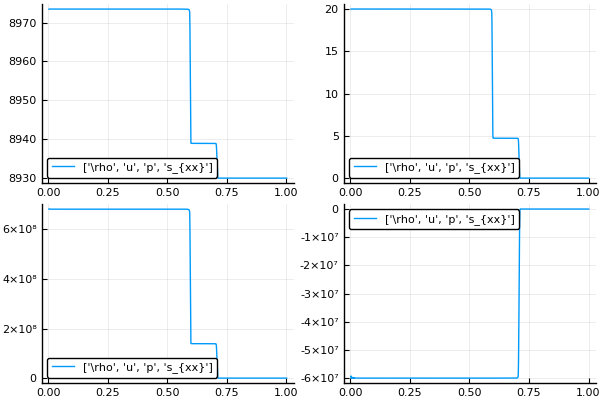

In [55]:
using Plots
using LaTeXStrings
pyplot()
plot(x1,uo1[:,1:4],layout=4,label=["\rho","u","p","s_{xx}"])

In [56]:
uo,u,x,inter = Wilkins()
xi = copy(x); ui = copy(uo);
@time uo2,x2 = TimeSolve(uo,x,inter)

  3.894166 seconds (94.51 M allocations: 7.877 GiB, 30.54% gc time)


([2785.0 7.04242 0.0 0.0; 2785.0 7.04242 0.0 0.0; … ; 2785.0 1.97874e-10 -0.0175537 -0.0155524; 2785.0 1.9787e-10 0.00877836 0.0107797], [0.000522309, 0.000584158, 0.000646006, 0.000708381, 0.000770755, 0.000833148, 0.000895538, 0.000957932, 0.00102032, 0.00108272  …  0.049625, 0.0496875, 0.04975, 0.0498125, 0.049875, 0.0499375, 0.05, 0.0500625, 0.050125, 0.0501875])

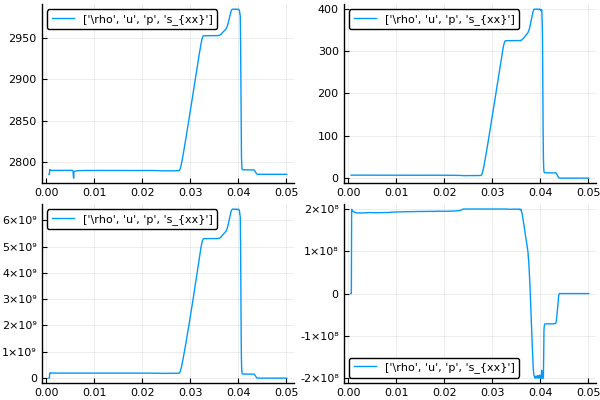

In [58]:
plot(x2,uo2[:,1:4],layout=4,label=["\rho","u","p","s_{xx}"])